# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

#### Definitions and functions

In [2]:
path_data = 'data/'
xs_corrections = { 'energy' : [88.4763 , 89.46658, 90.21986, 91.2291,  91.96428, 92.96229, 93.71362] ,
                      'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                      'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]}

s_selection = np.load(path_data+'s_selection.npy')

### These are the cuts determined in exercise 1 and 2 with the simulated data.

cuts = {'ee_s' : {'Pcharged':(0,200), 'Ncharged':(0,7),'E_ecal':(65,200),'E_hcal':(0,5),'cos_thet': (-0.9,s_selection[0])}, 
         'mm' : {'Pcharged':(63,200), 'Ncharged':(1,7),'E_ecal':(0,27),'E_hcal':(0,20)}, 
         'qq' : {'Pcharged':(0,200), 'Ncharged':(7,200),'E_ecal':(27,90),'E_hcal':(0,100)},
         'tt' : {'Pcharged':(0,63), 'Ncharged':(2,7),'E_ecal':(0,65),'E_hcal':(0,50)}}

In [3]:
# test if x is element of interval I
def isin(x,I):
    if x >= I[0] and x < I[1]: return True
    else: return False
    
def isequal(a,b):
    if a == b: return True
    else: return False

# categorize the events: put array indices of measured data into the corresponding energy category
# return dictionary with indices
def cat_energy(E_Lep,en_edges):
    energy_indices={'energy_1':[] ,'energy_2':[] ,'energy_3':[] ,'energy_4':[] ,'energy_5':[] , 'energy_6':[],
                    'energy_7':[]}
    
    i=0;
    for e in 2*E_Lep:
        if e<en_edges[1]:
            energy_indices['energy_1'].append(i)
        elif e>=en_edges[1] and e<en_edges[2]:
            energy_indices['energy_2'].append(i)
        elif e>=en_edges[2] and e<en_edges[3]:
            energy_indices['energy_3'].append(i)
        elif e>=en_edges[3] and e<en_edges[4]:
            energy_indices['energy_4'].append(i)
        elif e>=en_edges[4] and e<en_edges[5]:
            energy_indices['energy_5'].append(i)
        elif e>=en_edges[5] and e<en_edges[6]:
            energy_indices['energy_6'].append(i)
        elif e>=en_edges[6]:
            energy_indices['energy_7'].append(i)
        i+=1;
    
    return energy_indices

# categorize for each energy category the events, after the decay channel. The cuts are applied
def count_events(en_indices,cuts,Pchar,Nchar,E_ecal,E_hcal,cos_thet):
    event_counter = {'energy_1':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
                     'energy_2':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
                     'energy_3':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
                     'energy_4':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
                     'energy_5':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
                     'energy_6':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
                     'energy_7':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0}}
    
    measurements = {'Pcharged': Pchar, 'Ncharged': Nchar,'E_ecal': E_ecal,'E_hcal': E_hcal, 'cos_thet': cos_thet}
    
    for energy, indices in en_indices.items():
        for i in indices:
            for ch in cuts.keys():
                is_channel = True;
                for var, interval in cuts[ch].items():
                    if not isin(measurements[var][i],interval):
                        is_channel = False;
                if is_channel:
                    event_counter[energy][ch] += 1 
    return event_counter 

# # categorize for each energy category the events, after the decay channel. The cuts are applied
# def count_events(en_indices,cuts,Pchar,Nchar,E_ecal,E_hcal,cos_thet):
#     event_counter = {'energy_1':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
#                      'energy_2':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
#                      'energy_3':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
#                      'energy_4':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
#                      'energy_5':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
#                      'energy_6':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0},
#                      'energy_7':{'ee_s' : 0,'mm' : 0,'qq' : 0,'tt' : 0}}
    
#     for energy, indices in en_indices.items():
#         for i in indices:
#             if Nchar[i] > 7:
#                 event_counter[energy]['qq'] += 1;
#             elif E_ecal[i] > 70:
#                 if -0.9<= cos_thet[i] and cos_thet[i]< s_selection[0]: event_counter[energy]['ee_s'] += 1;
#             elif Pchar[i]>65:
#                 event_counter[energy]['mm']+=1;
#             else:
#                 event_counter[energy]['tt']+=1;
#     return event_counter 



#### Read in the OPAL data

In [4]:
rows = []
with open(path_data+'daten_3.csv','r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        rows.append(row)
mean_energy_opal=np.array(list(zip(*rows[1:]))[0], dtype=float)
lumi=np.array(list(zip(*rows[1:]))[1], dtype=float)
stat=np.array(list(zip(*rows[1:]))[2], dtype=float)
sys=np.array(list(zip(*rows[1:]))[3], dtype=float)
sq_sum=np.array(list(zip(*rows[1:]))[4], dtype=float)

lum_data = {'energy_1': {'lumi': lumi[0] ,'stat': stat[0] , 'sys': sys[0],'all': sq_sum[0]},
            'energy_2': {'lumi': lumi[1] ,'stat': stat[1] , 'sys': sys[1],'all': sq_sum[1]},
            'energy_3': {'lumi': lumi[2] ,'stat': stat[2] , 'sys': sys[2],'all': sq_sum[2]},
            'energy_4': {'lumi': lumi[3] ,'stat': stat[3] , 'sys': sys[3],'all': sq_sum[3]},
            'energy_5': {'lumi': lumi[4] ,'stat': stat[4] , 'sys': sys[4],'all': sq_sum[4]},
            'energy_6': {'lumi': lumi[5] ,'stat': stat[5] , 'sys': sys[5],'all': sq_sum[5]},
            'energy_7': {'lumi': lumi[6] ,'stat': stat[6] , 'sys': sys[6],'all': sq_sum[6]}}

In [5]:
### Open the file introducing file path
opal_data = uproot.open(path_data+'daten_3.root')
ttree_name = 'myTTree'

In [6]:
### Load branches
branches_opal = opal_data[ttree_name].arrays()

In [7]:
### These are arrays of same length
Nchar = ak.to_numpy(branches_opal['Ncharged'])
Pchar = ak.to_numpy(branches_opal['Pcharged'])
E_Ecal = ak.to_numpy(branches_opal['E_ecal'])
E_Hcal = ak.to_numpy(branches_opal['E_hcal'])
E_Lep = ak.to_numpy(branches_opal['E_lep'])
cos_thet = ak.to_numpy(branches_opal['cos_thet'])

#### Event selection
The data contains events, corresponding to different energies. For a propper calculation of cross sections, those events are categorized to the energies mentioned in the csv_file.

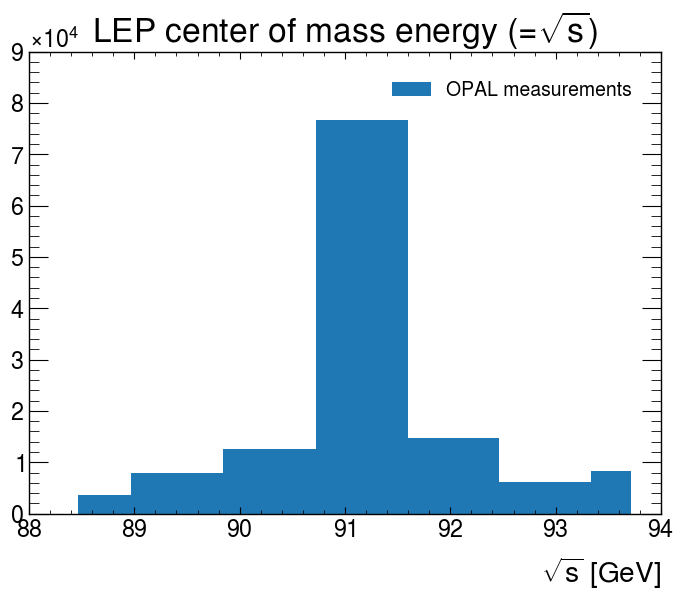

In [8]:
en_edges=[min(2*E_Lep)]
for i in range(6):
    en_edges.append((mean_energy_opal[i]+mean_energy_opal[i+1])/2)
    
en_edges.append(max(2*E_Lep))

# print(en_edges)
plt.style.use(mplhep.style.ATLAS) # load ATLAS plot style
plt.title(r'LEP center of mass energy (=$\sqrt{s}$)')
hbins, hedges, _ = plt.hist(2*E_Lep,bins= en_edges,label=r'OPAL measurements')

plt.xlim(88,94)
plt.xlabel(r'$\sqrt{s}$ $[GeV]$')
plt.legend()
plt.show()

In [9]:
### Apply the event selection functions defined above
energy_indices = cat_energy(E_Lep,en_edges)
# Test of means of our categorizations fits the mean energy given in the csv file:

energy_means = []
energy_sigma = []

for energy, indices in energy_indices.items():
    e_mean = 0
    e_sigma=0
    for i in indices:
        e_mean += 2*E_Lep[i]
    e_mean = e_mean / len(indices)
    for i in indices:
        e_sigma += (2*E_Lep[i] - e_mean)**2
    e_sigma = np.sqrt(e_sigma/ len(indices))
    energy_means.append(e_mean)
    energy_sigma.append(e_sigma)
    

energy_means = np.array(energy_means)
energy_sigma = np.array(energy_sigma)

# print(np.linalg.norm(energy_means-mean_energy_opal))
# print(energy_sigma)
# The error on the energy is to small to play any role

In [10]:
event_counter = count_events(energy_indices,cuts,Pchar,Nchar,E_Ecal,E_Hcal,cos_thet)

In [11]:
### Test if the event categorization worked
counter=0;
for energy, indices in energy_indices.items():
    counter+=len(indices)
    
### Test if the energy categorization worked    
counter1=0;
for energy, index_lists in event_counter.items():
    for channel, count in index_lists.items():
        counter1 += count;

print(len(E_Lep))
print(counter)
print(counter1) # counter1<total number of events ?? Backround ?

130051
130051
110924


#### Calculation of the cross sections

In [12]:
### Read in efficiency matrix, error matrix and thei inverses (from  Exercise 1)
efficiency_matrix = np.load(path_data+'efficiency_matrix.npy')
error_matrix = np.load(path_data+'error_matrix.npy')
inv_efficiency_matrix = np.load(path_data+'inv_efficiency_matrix.npy')
inv_error_matrix = np.load(path_data+'inv_error_matrix.npy')
s_correction_factor= np.array([s_selection[1],1,1,1])
s_correction_error = np.array([s_selection[2],0,0,0])

In [13]:
### Calculate the total cross sections for each energy level
sigma = {'energy_1': np.zeros(4),'energy_2': np.zeros(4),'energy_3': np.zeros(4),'energy_4': np.zeros(4),
         'energy_5': np.zeros(4),'energy_6': np.zeros(4),'energy_7': np.zeros(4)}

d_sigma_stat = {'energy_1': np.zeros(4),'energy_2': np.zeros(4),'energy_3': np.zeros(4),'energy_4': np.zeros(4),
                'energy_5': np.zeros(4),'energy_6': np.zeros(4),'energy_7': np.zeros(4)}

d_sigma_sys = {'energy_1': np.zeros(4),'energy_2': np.zeros(4),'energy_3': np.zeros(4),'energy_4': np.zeros(4),
               'energy_5': np.zeros(4),'energy_6': np.zeros(4),'energy_7': np.zeros(4)}

energy_el= {'energy_1': 0, 'energy_2': 1, 'energy_3': 2, 'energy_4': 3, 'energy_5': 4, 'energy_6': 5, 'energy_7': 6}


for energy, counters in event_counter.items():
    counter_array = np.zeros(4);
    
    el={'ee_s': 0,'mm':1,'qq':2,'tt':3}
    sigma_corr = np.array([xs_corrections['leptonic'][energy_el[energy]],xs_corrections['leptonic'][energy_el[energy]],
                           xs_corrections['hadronic'][energy_el[energy]],xs_corrections['leptonic'][energy_el[energy]]])
    for channel in counters:
        counter_array[el[channel]]= event_counter[energy][channel]
        
    # Calculate cross section
    sigma[energy] = np.dot(inv_efficiency_matrix,counter_array)*s_correction_factor/lum_data[energy]['lumi'] +sigma_corr
    
    # Calculate statistical error via propagation for cross section
    d_sigma_stat[energy] = np.sqrt((np.dot(inv_error_matrix**2,counter_array**2)*s_correction_factor**2/lum_data[energy]['lumi']**2)
                             +(np.dot(inv_efficiency_matrix**2,counter_array**2)*s_correction_error**2/lum_data[energy]['lumi']**2)
                             +(np.dot(inv_efficiency_matrix**2,counter_array**2)*s_correction_factor**2*lum_data[energy]['stat']**2)
                              *(1/lum_data[energy]['lumi'])**4)
    
    # Calculate systematical error via propagation for cross section
    d_sigma_sys[energy] = (np.dot(inv_efficiency_matrix,counter_array)*s_correction_factor*lum_data[energy]['stat']
                            *(1/lum_data[energy]['lumi'])**2)


# Example for e+e- to e+e- at 88.4763 GeV
print(f"sigma = {sigma['energy_1'][0]} +/- {d_sigma_stat['energy_1'][0]} (stat) +/- {d_sigma_sys['energy_1'][0]} (sys)")

sigma = 0.12463598114904426 +/- 0.004311015325728622 (stat) +/- 0.00023216151391977942 (sys)


#### Plot the results. Breit-Wiger-Fit:

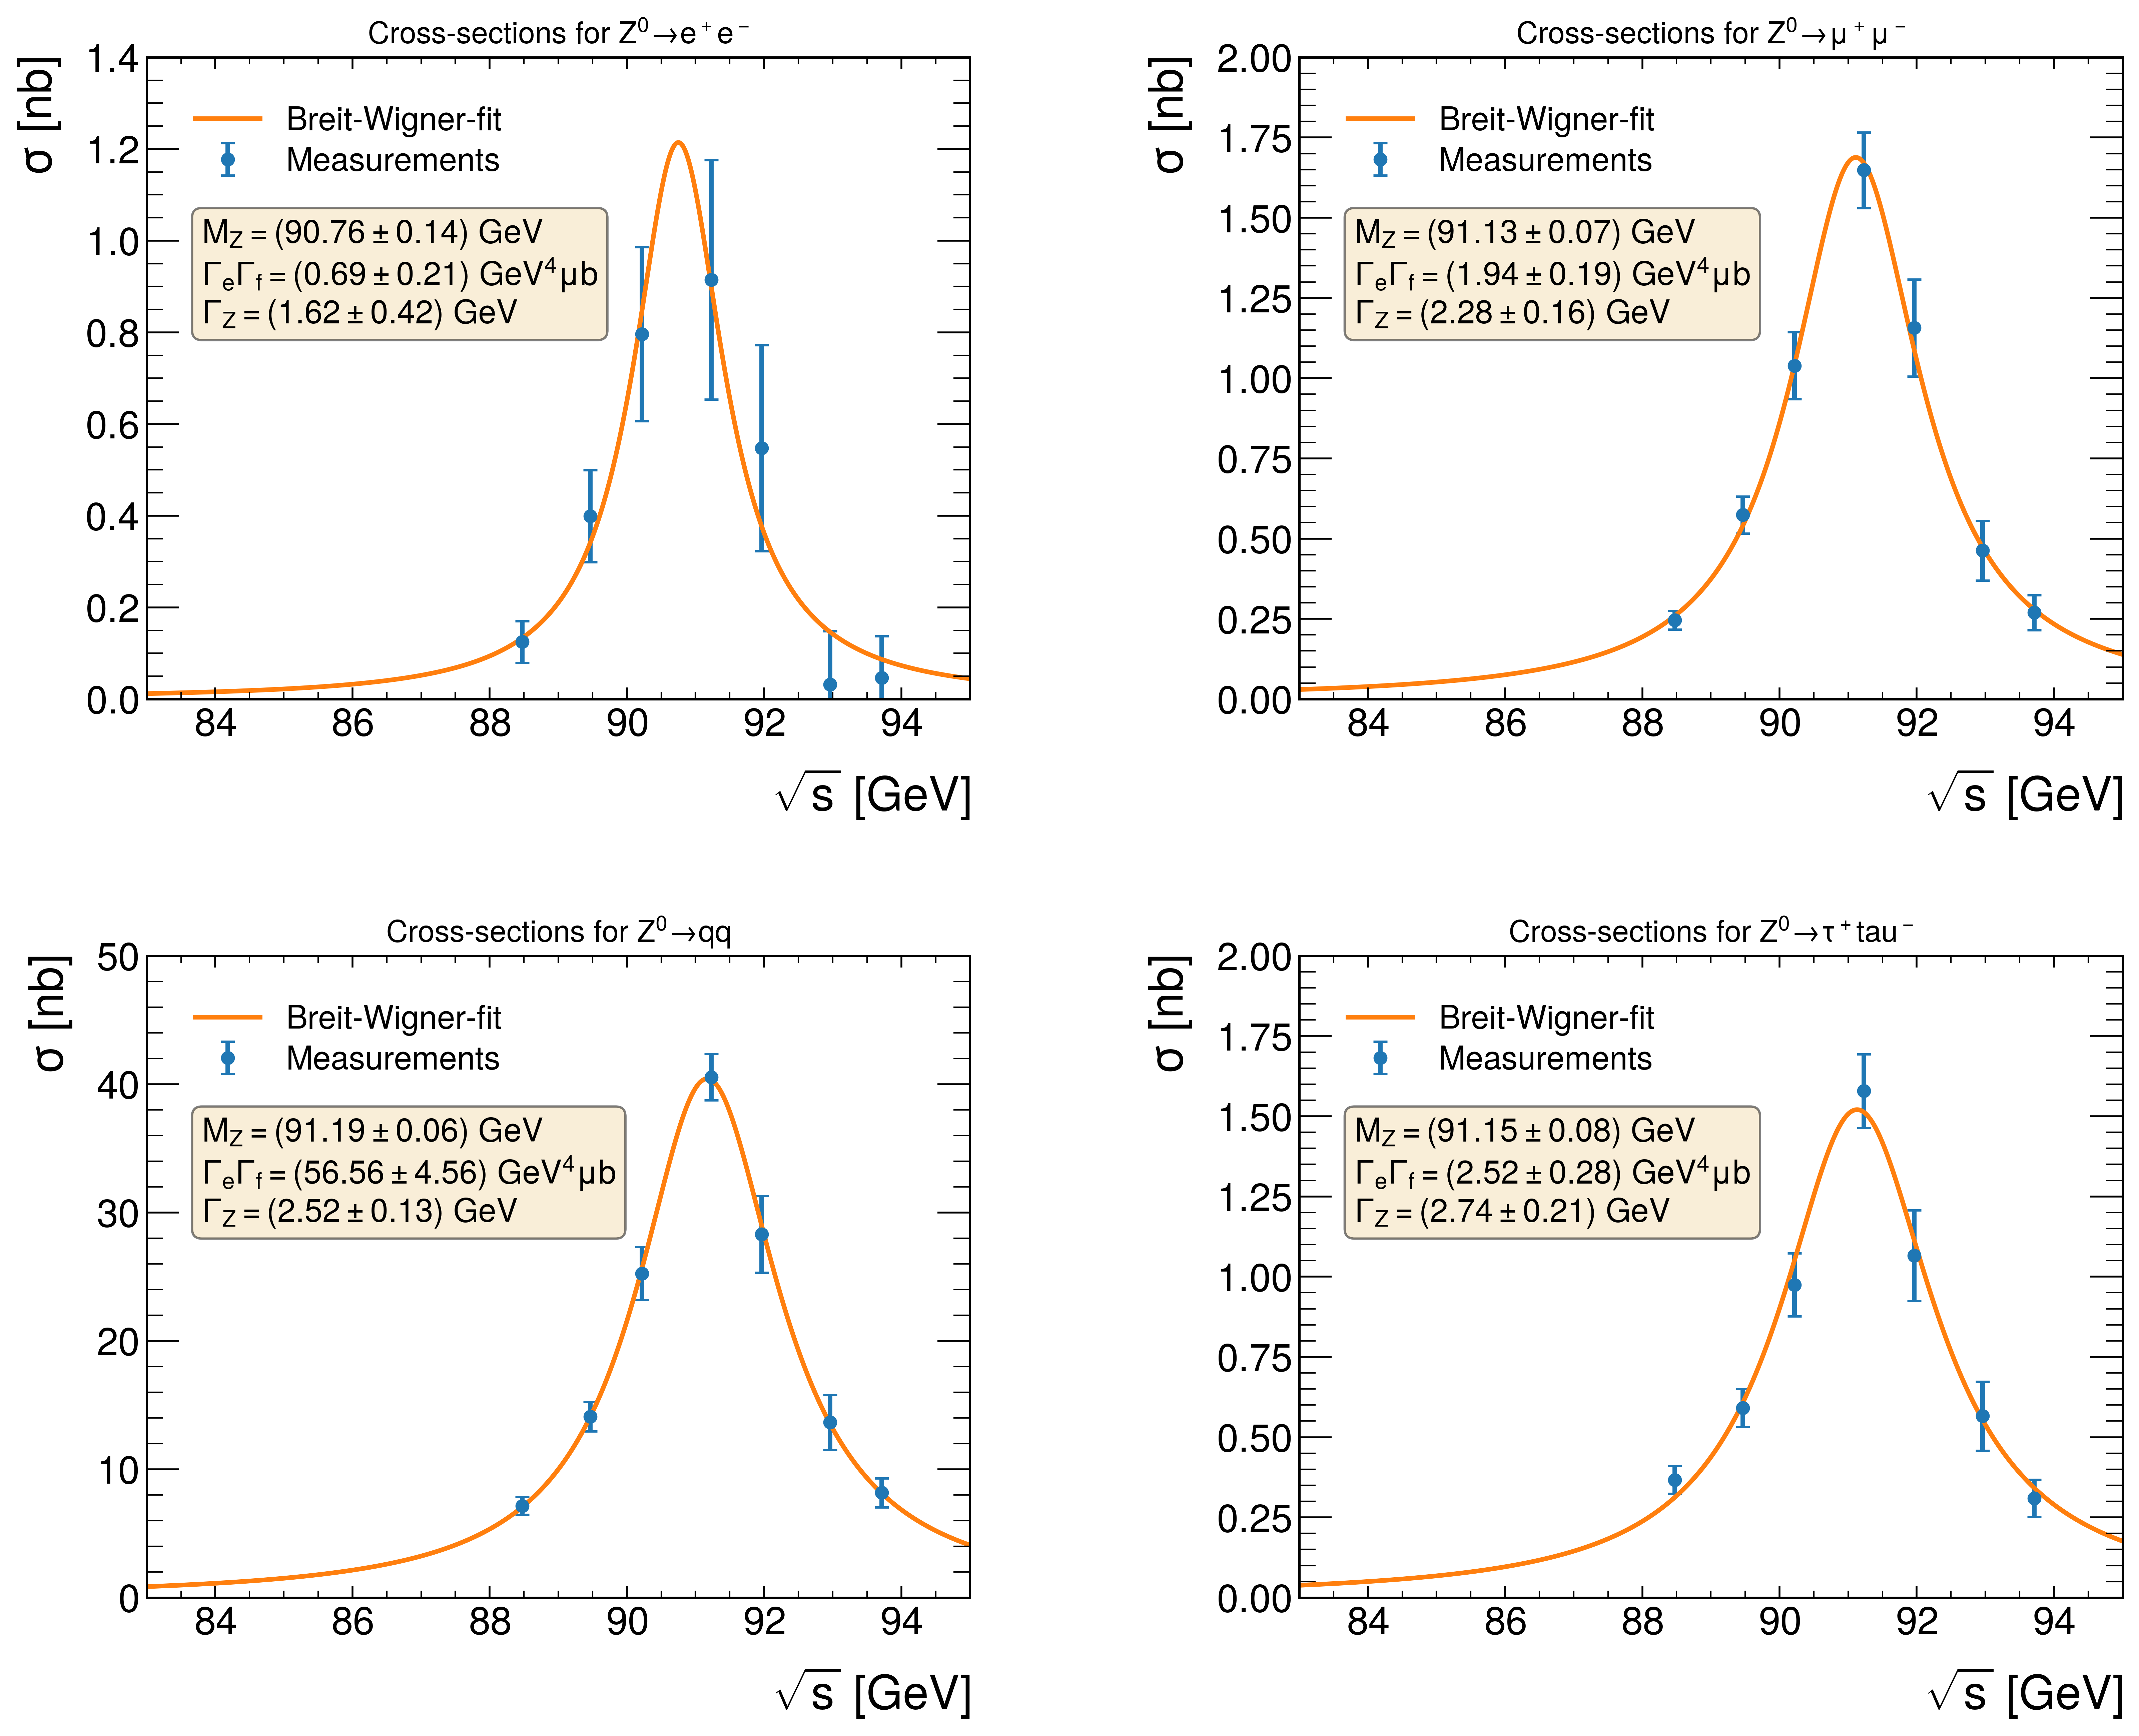

In [16]:
# Store the results in numpy arrays, in order to make nice plots with matplotlip.pyplot

sigma_arr = np.zeros((4,7))
sigma_stat_arr = np.zeros((4,7))
sigma_sys_arr = np.zeros((4,7))

for energy in sigma.keys():
    sigma_arr[0][energy_el[energy]] = sigma[energy][0]
    sigma_arr[1][energy_el[energy]] = sigma[energy][1]
    sigma_arr[2][energy_el[energy]] = sigma[energy][2]
    sigma_arr[3][energy_el[energy]] = sigma[energy][3]
    sigma_stat_arr[0][energy_el[energy]] = d_sigma_stat[energy][0]
    sigma_stat_arr[1][energy_el[energy]] = d_sigma_stat[energy][1]
    sigma_stat_arr[2][energy_el[energy]] = d_sigma_stat[energy][2]
    sigma_stat_arr[3][energy_el[energy]] = d_sigma_stat[energy][3]
    sigma_sys_arr[0][energy_el[energy]] = d_sigma_sys[energy][0]
    sigma_sys_arr[1][energy_el[energy]] = d_sigma_sys[energy][1]
    sigma_sys_arr[2][energy_el[energy]] = d_sigma_sys[energy][2]
    sigma_sys_arr[3][energy_el[energy]] = d_sigma_sys[energy][3]   
    
d_sigma_arr = sigma_stat_arr + sigma_sys_arr

fig, ax = plt.subplots(figsize=(15, 12),dpi=500)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
plt.style.use(mplhep.style.ATLAS) # load ATLAS plot style
def breit_wigner(sqrt_s,M,Gamma_ef,Gamma_Z):
    s=sqrt_s**2
    return 12*np.pi/M**2*(s*Gamma_ef)/((s-M**2)**2+(s**2*Gamma_Z**2/M**2))



# Scale the errors by a factor of 10, in order to make them visible in the plot
d_sigma_arr= d_sigma_arr*10
headers=[r'Cross-sections for $Z^0\to e^+e^-$',r'Cross-sections for $Z^0\to \mu^+\mu^-$',
       r'Cross-sections for $Z^0\to qq$',r'Cross-sections for $Z^0\to \tau^+tau^-$']
# Generate errorbar plot of the results for the cross section
for i in range(4):
    ax = plt.subplot(221+i)
    ax.set_title(headers[i], fontsize=13)
    ax.errorbar(energy_means, sigma_arr[i], d_sigma_arr[i],marker='.',linestyle='None',label=r'Measurements',markersize=10,capsize=3, capthick=1)
    
    coeffs, cov = curve_fit(breit_wigner, energy_means, sigma_arr[i],sigma=d_sigma_arr[i], 
                            absolute_sigma=True,p0=[91.1,240*240,2.5])
    x=np.linspace(83, 95, 1000)
    ax.plot(x,breit_wigner(x,*coeffs),label=r'Breit-Wigner-fit')
    ax.set_xlim(83,95)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(r'$\sqrt{s}$ [GeV]')
    ax.set_ylabel(r'$\sigma$ [nb]')
    ax.legend() 
    
    
    # these are matplotlib.patch.Patch properties
    textstr = '\n'.join((
    r'$M_Z=(%.2f \pm %.2f) $ GeV' % (np.abs(coeffs[0]),np.sqrt(cov[0][0]), ),
    r'$\Gamma_e \Gamma_f=(%.2f \pm %.2f)$ GeV$^4\mu$b' % (coeffs[1]/1000,np.sqrt(cov[1][1])/1000, ),
    r'$\Gamma_Z=(%.2f \pm %.2f) $ GeV ' % (coeffs[2],np.sqrt(cov[2][2]), )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.067, 0.75, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    

       
plt.show()